In [240]:
%reset
'''
From OpenAI gym.
https://gym.openai.com/envs/FrozenLake-v0/

The agent controls the movement of a character in a grid world. 
Some tiles of the grid are walkable, and others lead to the agent falling into the water. 
Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction.
The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
'''

'\nFrom OpenAI gym.\nhttps://gym.openai.com/envs/FrozenLake-v0/\n\nThe agent controls the movement of a character in a grid world. \nSome tiles of the grid are walkable, and others lead to the agent falling into the water. \nAdditionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction.\nThe agent is rewarded for finding a walkable path to a goal tile.\n\nThe surface is described using a grid like the following:\nSFFF       (S: starting point, safe)\nFHFH       (F: frozen surface, safe)\nFFFH       (H: hole, fall to your doom)\nHFFG       (G: goal, where the frisbee is located)\n'

# Q-Table Learning

In [241]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load environment.
environment = gym.make('FrozenLake-v0')

In [242]:
def evaluate(for_viz, no_rewards, no_episodes, no_steps=None):
    print('Score over time: {}'.format(str(sum(no_rewards)/no_episodes)))
    print('Final Q-Table Values')
    print(Q)
    print('')

    for_viz = pd.DataFrame(for_viz, columns=['episode', 'reward_sum'])
    plt.figure(figsize=(10,5))
    sns.pointplot(x='episode', y='reward_sum', data=for_viz)

Score over time: 0.4435
Final Q-Table Values
[[8.43877053e-02 6.33303082e-03 2.34830695e-03 6.09044065e-03]
 [8.51153584e-05 1.43132265e-03 4.93145717e-04 6.86296850e-02]
 [4.10155065e-03 2.53470958e-03 3.64968635e-03 8.10000225e-02]
 [1.80587192e-04 9.25496603e-04 1.28210129e-04 5.72030537e-02]
 [1.43846549e-01 1.10634335e-04 4.45348258e-03 6.50039444e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00372413e-02 1.76036680e-04 5.51257120e-05 2.17686137e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.46030551e-04 1.26365788e-03 1.78299548e-04 3.25695891e-01]
 [2.58753133e-04 2.01346747e-01 6.97556477e-04 1.28969360e-04]
 [7.32648943e-02 2.15656918e-04 3.37840682e-05 2.89464465e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.57652606e-03 0.00000000e+00 7.22537582e-01 4.56162525e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.64456140e-01]
 [0.000000

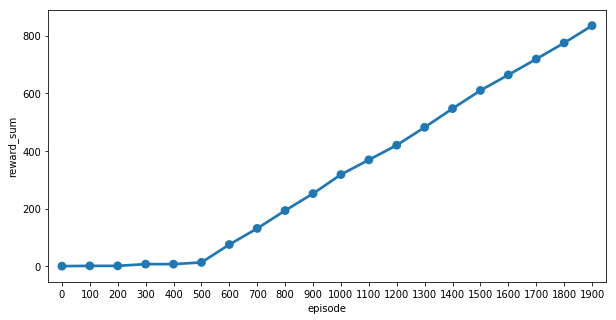

In [243]:
# Initialize table with zeros.
Q = np.zeros([environment.observation_space.n, environment.action_space.n])

# Learning parameters.
lr = .8  # Learning rate.
y = .95  # Discount rate.
no_episodes = 2000

no_rewards = []
for_viz = []
for episode in range(no_episodes):
    # Reset environment and get first new observation.
    state = environment.reset()
    reward_all = 0
    done = False  # Done. If true, then episode is done.
    step_number = 0  # Iterator. Number of steps in episode.
    # The Q-Table learning algorithm.
    while step_number < 99:
        step_number += 1
        # Choose an action by greedily (with noise) picking from Q table
        # Noise is important. It's allows to choose different initial actions
        action = (np.argmax(Q[state,:] +
                            np.random.randn(1, environment.action_space.n)*(1./(episode+1))))
        # Get new state and reward from environment.
        state1, reward, done, _ = environment.step(action)
        # Update Q-Table with new knowledge
        # Use learning rate: If you think of the Q algorithm in the context of gradient descent, 
        # then `r + γ(max(Q(s’,a’))` is what we would like to approach, 
        # but we know that it is a noisy estimate of the true Q value 
        # for that given region. So instead of directly updating toward it,
        # we take a small step in the direction that will make the Q value
        # closer to the desired one.
        Q[state, action] = (Q[state, action]
                            + lr*(reward + y*np.max(Q[state1, :]) - Q[state, action]))
        reward_all += reward
        state = state1
        if done == True:
            break
    no_rewards.append(reward_all)
    if episode % 100 == 0:
        for_viz.append((episode, sum(no_rewards)))
    
evaluate(for_viz, no_rewards, no_episodes)

# Q-learning with neural network(s)

In [ ]:
'''
While it is easy to have a 16x4 table for a simple grid world, 
the number of possible states in any modern game or real-world environment is nearly infinitely larger. 
For most interesting problems, tables simply don’t work. 
We instead need some way to take a description of our state, and produce Q-values for actions without a table: that is where neural networks come in. 
By acting as a function approximator, we can take any number of possible states that can be represented as a vector and learn to map them to Q-values.

In the case of the FrozenLake example, we will be using a one-layer network which takes the state encoded in a one-hot vector (1x16), 
and produces a vector of 4 Q-values, one for each action. Such a simple network acts kind of like a glorified table, 
with the network weights serving as the old cells. The key difference is that we can easily expand the Tensorflow network with added layers, 
activation functions, and different input types, whereas all that is impossible with a regular table. 
The method of updating is a little different as well.
Instead of directly updating our table, with a network we will be using backpropagation and a loss function. 
Our loss function will be sum-of-squares loss, where the difference between the current predicted Q-values, 
and the “target” value is computed and the gradients passed through the network. 
In this case, our Q-target for the chosen action is the equivalent to the Q-value.

Loss = ∑(Q-target - Q)²
'''

In [244]:
import random
import tensorflow as tf

tf.reset_default_graph()

# These lines establish the feed-forward part of the network used to choose actions.
inputs1 = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01))
Qout = tf.matmul(inputs1, W)
predict = tf.argmax(Qout, 1)

# Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1, 4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

Score over time: 0.0355
Final Q-Table Values
[[8.43877053e-02 6.33303082e-03 2.34830695e-03 6.09044065e-03]
 [8.51153584e-05 1.43132265e-03 4.93145717e-04 6.86296850e-02]
 [4.10155065e-03 2.53470958e-03 3.64968635e-03 8.10000225e-02]
 [1.80587192e-04 9.25496603e-04 1.28210129e-04 5.72030537e-02]
 [1.43846549e-01 1.10634335e-04 4.45348258e-03 6.50039444e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00372413e-02 1.76036680e-04 5.51257120e-05 2.17686137e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.46030551e-04 1.26365788e-03 1.78299548e-04 3.25695891e-01]
 [2.58753133e-04 2.01346747e-01 6.97556477e-04 1.28969360e-04]
 [7.32648943e-02 2.15656918e-04 3.37840682e-05 2.89464465e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.57652606e-03 0.00000000e+00 7.22537582e-01 4.56162525e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.64456140e-01]
 [0.000000

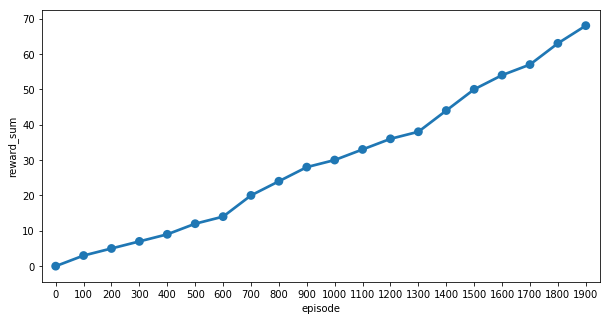

In [253]:
%%time
init = tf.initialize_all_variables()

# Set learning parameters.
y = .99
e = 0.1
num_episodes = 2000
# Create lists to contain total rewards and steps per episode.
no_rewards = []
no_steps = []

for_viz = []
with tf.Session() as sess:
    sess.run(init)
    for episode in range(num_episodes):
        # Reset environment and get first new observation.
        s = environment.reset()
        reward_all = 0
        done = False
        step_number = 0
        # The Q-Network.
        while step_number < 99:
            step_number += 1
            # Choose an action by greedily (with e chance of random action) from the Q-network.
            action, allQ = sess.run([predict, Qout], feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                action[0] = environment.action_space.sample()
            # Get new state and reward from environment.
            state1, reward, done, _ = environment.step(action[0])
            # Obtain the Q' values by feeding the new state through our network.
            Q1 = sess.run(Qout, feed_dict={inputs1:np.identity(16)[state1:state1+1]})
            # Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, action[0]] = reward + y*maxQ1
            # Train our network using target and predicted Q values.
            _, W1 = sess.run([updateModel, W], feed_dict={inputs1:np.identity(16)[s:s+1], nextQ:targetQ})
            reward_all += reward
            state = state1
            if done == True:
                # Reduce chance of random action as we train the model.
                e = 1./((episode/50) + 10)
                break
        no_steps.append(step_number)
        no_rewards.append(reward_all)
        if episode % 100 == 0:
            for_viz.append((episode, sum(no_rewards)))
    
evaluate(for_viz, no_rewards, no_episodes) 